# Space Mission Challenge - IEEE Hackathonn 2023
## Pumping Lemma Submission 

The year is 2030, a team of space enthusiasts launched a mission to explorea distant planet in a far-off galaxy. 

The mission was a challenging one, and the team had to overcome several obstacles to make it a success.

This event is about analyzing the data from the mission to determine its success rate and building an autonomous system for the spaceship.

## Importing the libraries


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import arcade
import random
import pyglet
import math
import numpy as np

from collections import deque
from Helper import plot

%matplotlib inline


c:\Python310\lib\site-packages\pyglet\libs\win32\__init__.py:326: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


## Hardcoded Game Parameters

In [2]:
SCREEN_WIDTH = 1200
SCREEN_HEIGHT = 800
SPACESHIP_SPEED = 0.01
GRAVITATIONAL_FORCE = 5


## The Spaceship

In [3]:
class Spaceship:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.velocity_x = 0
        self.velocity_y = 0
        self.angle = 0
        self.pulling_planet = None

    def draw(self):
        arcade.draw_rectangle_filled(
            self.x, self.y, 20, 20, arcade.color.BLUE, self.angle)

    def move(self, net_force, angle):
        self.velocity_x += net_force * math.cos(math.radians(angle))
        self.velocity_y += net_force * math.sin(math.radians(angle))
        self.x += self.velocity_x
        self.y += self.velocity_y

    def apply_gravity(self, planet):
        # Gravity of planet
        dx = planet.x - self.x
        dy = planet.y - self.y
        distance = math.sqrt(dx**2 + dy**2)
        force = GRAVITATIONAL_FORCE * planet.size / distance**2

        # Gravity of current strongest planet
        if self.pulling_planet is not None:
            d2x = self.pulling_planet.x - self.x
            d2y = self.pulling_planet.y - self.y
            distance = math.sqrt(d2x**2 + d2y**2)
            old_force = GRAVITATIONAL_FORCE * self.pulling_planet.size / distance**2
            if force > old_force:
                self.pulling_planet = planet
        else:
            self.pulling_planet = planet

        angle = math.degrees(math.atan2(dy, dx))
        self.move(force, angle)

    def collides_with(self, planet):
        dx = planet.x - self.x
        dy = planet.y - self.y
        distance = math.sqrt(dx**2 + dy**2)
        return distance <= (planet.size + 15 + (20 if planet.is_green else 0))


## The Planet

In [4]:
class Planet:
    def __init__(self, x, y, size, is_green):
        self.x = x
        self.y = y
        self.size = size
        self.is_green = is_green

    def draw(self):
        color = arcade.color.GREEN if self.is_green else arcade.color.WHITE
        arcade.draw_circle_filled(self.x, self.y, self.size, color)
        if self.is_green:
            arcade.draw_circle_outline(self.x, self.y, self.size + 20, color)


## The Model To Be Trained

In [5]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    def save(self, file_name="model.pth"):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)


class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)

        if len(state.shape) == 1:
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        pred = self.model(state)
        target = pred.clone()

        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * \
                    torch.max(self.model(next_state[idx]))
            target[idx][torch.argmax(action[idx]).item()] = Q_new

        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()


## The Agent

In [6]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001


class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0  # control the randomness
        self.gamma = 0.9  # discount rate
        # Elements will be removed from the left if exceeded
        self.memory = deque(maxlen=MAX_MEMORY)
        self.model = Linear_QNet(16, 256, 4)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

    def get_state(self, game):

        spaceship = game.get_spaceship()

        destination = None

        obstacle = spaceship.pulling_planet

        for planet in game.planets:
            if (planet.is_green):
                destination = planet

        state = [

            # up
            (spaceship.velocity_y < 0),
            # down
            (spaceship.velocity_y > 0),
            # left
            (spaceship.velocity_x < 0),
            # right
            (spaceship.velocity_x > 0),

            # Danger - Right Wall collision
            (spaceship.velocity_x > 0 and spaceship.x > game.get_screen_width() - 5),
            # Danger - Up wall collision
            (spaceship.velocity_y < 0 and spaceship.y < 5),
            # Danger - Left wall collision
            (spaceship.velocity_x < 0 and spaceship.x < 5),
            # Danger - Down Wall collision
            (spaceship.velocity_y > 0 and spaceship.x > game.get_screen_height() - 5),

            #destination is up
            (destination.y < spaceship.y),
            #destination is down
            (destination.y > spaceship.y),
            #destination is right
            (destination.x > spaceship.x),
            #destination is left
            (destination.x < spaceship.x),

            #obstacle is up
            (obstacle is not None and obstacle.y < spaceship.y),
            #obstacle is down
            (obstacle is not None and obstacle.y > spaceship.y),
            #obstacle is right
            (obstacle is not None and obstacle.x > spaceship.x),
            #obstacle is left
            (obstacle is not None and obstacle.x < spaceship.x)
        ]
        return np.array(state, dtype=int)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE)
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)

    def train_short_memory(self, state, action, reward, next_state, done):
        self.trainer.train_step(state, action, reward, next_state, done)

    def get_action(self, state):
        # random moves at first
        self.epsilon = 80 - self.n_games
        final_move = [0, 0, 0, 0]
        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 3)
            final_move[move] = 1
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move


## The Game

In [7]:

class Game(arcade.Window):

    def __init__(self, title):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, title)
        self.is_running = True
        self.push_handlers(on_key_press=self.on_key_press)
        # print(self.get_event_handlers)

        arcade.set_background_color(arcade.color.BLACK)
        self.planets = []
        self.green_planet_index = random.randint(0, 4)
        for i in range(5):
            x = random.randint(0, SCREEN_WIDTH)
            y = random.randint(0, SCREEN_HEIGHT)
            size = random.randint(10, 20)
            is_green = i == self.green_planet_index
            self.planets.append(Planet(x, y, size, is_green))
        self.spaceship = Spaceship(50, SCREEN_HEIGHT//2)

    def setup(self):
        pass

    def on_update(self, delta_time):
        for planet in self.planets:
            if planet.is_green and self.spaceship.collides_with(planet):
                arcade.draw_text("Congratulations!", SCREEN_WIDTH/2, SCREEN_HEIGHT/2,
                                 arcade.color.WHITE, font_size=50, anchor_x="center")
                #print("you won!!!")
                self.is_running = False
                # reward done, score
                return (100, True, 1)
            self.spaceship.apply_gravity(planet)
        if self.spaceship.x < 0 or self.spaceship.x > SCREEN_WIDTH or self.spaceship.y < 0 or self.spaceship.y > SCREEN_HEIGHT:
            self.is_running = False
            return (-100, True, 0)
        self.spaceship.move(SPACESHIP_SPEED, self.spaceship.angle)

        return (0, False, 0)

    def on_draw(self, n_games):
        if self.is_running:
            arcade.start_render()
            arcade.draw_text("Flight#: " + str(n_games), SCREEN_WIDTH/2, SCREEN_HEIGHT/2,
                             arcade.color.WHITE, font_size=25, anchor_x="center")
            for planet in self.planets:
                planet.draw()
            self.spaceship.draw()

    def on_key_press(self, key, modifiers):
        if key == arcade.key.LEFT:
            self.spaceship.angle = 180
        elif key == arcade.key.RIGHT:
            self.spaceship.angle = 0
        elif key == arcade.key.UP:
            self.spaceship.angle = 90
        elif key == arcade.key.DOWN:
            self.spaceship.angle = 270
        print("Key pressed:", key)

    def action(self, action):
        if np.array_equal(action, [1, 0, 0, 0]):  # up
            self.spaceship.angle = 90
        elif np.array_equal(action, [0, 1, 0, 0]):  # down
            self.spaceship.angle = 270
        elif np.array_equal(action, [0, 0, 1, 0]):  # left
            self.spaceship.angle = 180
        elif np.array_equal(action, [0, 0, 0, 1]):  # right
            self.spaceship.angle = 0

    def run(self):
        # Set up the game loop
        plot_scores = []
        plot_mean_scores = []
        total_score = 0
        record = 0

        agent = Agent()

        notDoneForGood = True

        while notDoneForGood:
            # get state of the game
            state_old = agent.get_state(self)

            # conjure up a move using the forbidden dark arts
            final_move = agent.get_action(state_old)
            # get whatever resulted from that move
            self.action(final_move)
            # Call the update() method with the time since the last frame
            reward, done, score = self.on_update(1/60)

            state_new = agent.get_state(self)

            # train the short memory
            agent.train_short_memory(
                state_old, final_move, reward, state_new, done)

            # remember
            agent.remember(state_old, final_move, reward, state_new, done)

            if done:
                self.reset()
                agent.n_games += 1

                if score > record:
                    record = score
                    agent.model.save()

                plot_scores.append(score)
                total_score += score
                mean_score = total_score / agent.n_games
                plot_mean_scores.append(mean_score)

                if agent.n_games >= 10000:
                    plot(plot_scores, plot_mean_scores)
                    print(total_score, " landings made out of 100,000")
                    notDoneForGood = False
                    self.is_running = False

            if self.is_running:

                arcade.start_render()

                # Call the on_draw() method to draw the game objects
                self.on_draw(agent.n_games)

                # Swap buffers to display the rendered frame
                arcade.finish_render()

                # Sleep to enforce the desired frame rate
                # arcade.pause(1/60)
            else:
                self.close()

    def reset(self):
        self.is_running = True
        self.planets = []
        self.green_planet_index = random.randint(0, 4)
        for i in range(5):
            x = random.randint(200, SCREEN_WIDTH)
            y = random.randint(0, SCREEN_HEIGHT)
            size = random.randint(10, 20)
            is_green = i == self.green_planet_index
            self.planets.append(Planet(x, y, size, is_green))
        self.spaceship = Spaceship(50, SCREEN_HEIGHT // 2)

    def get_frame(self):
        arcade.start_render()
        self.on_draw()
        arcade.finish_render()

        buffer = pyglet.image.get_buffer_manager().get_color_buffer()
        image_data = buffer.get_image_data()
        arr = np.frombuffer(image_data.data, dtype=np.uint8)
        arr = arr.reshape(buffer.height, buffer.width, 4)
        return arr[::-1]

    def get_spaceship(self):
        return self.spaceship

    def get_screen_width(self):
        return SCREEN_WIDTH

    def get_screen_height(self):
        return SCREEN_HEIGHT


## Plot of Good Landings vs 10,000 flights (Landing Success Rate)
### *As the agent learns

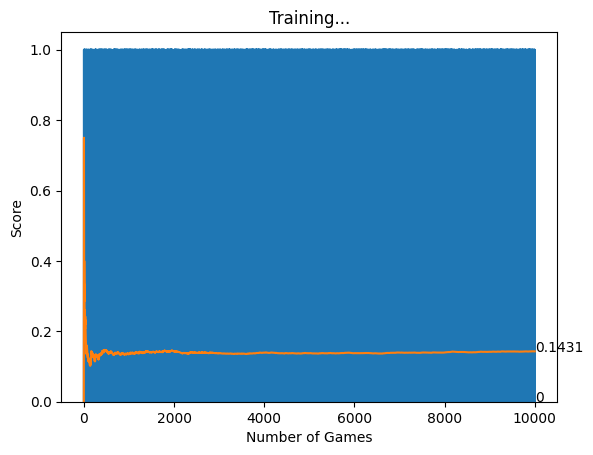

1431  landings made out of 100,000


In [8]:
game = Game('Spaceship Game')
game.setup()
game.run()
